# Лабораторная работа №4

ФИО:  **Селифонов Артём Евгеньевич**
Группа: **БИВТ-20-1**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

In [1]:
!pip install -q datasets

from datasets import load_dataset

dataset = load_dataset('Matthijs/snacks') 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.0 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [83]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

In [2]:
labels = dataset["test"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    print(i, label)
    label2id[label] = i
    id2label[i] = label

0 apple
1 banana
2 cake
3 candy
4 carrot
5 cookie
6 doughnut
7 grape
8 hot dog
9 ice cream
10 juice
11 muffin
12 orange
13 pineapple
14 popcorn
15 pretzel
16 salad
17 strawberry
18 waffle
19 watermelon


In [3]:
type(dataset['train'][1]['image'])

PIL.JpegImagePlugin.JpegImageFile

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [151]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):
        
      self.input_data = input_data
      # Transform input data
      self.transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

  def __len__(self):
      return len(self.input_data)
    
  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])
  
  def get_labels(self, idx):
      return self.input_data[idx]['label']
  
  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

# Шаги 1-3

#### snacks


In [152]:
train_dataset = ImageDataset(dataset["train"])
test_dataset = ImageDataset(dataset["test"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = dataset["test"].features["label"].names
dataset_sizes = {
    'train': len(dataset['train']),
    'test': len(dataset['test']),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

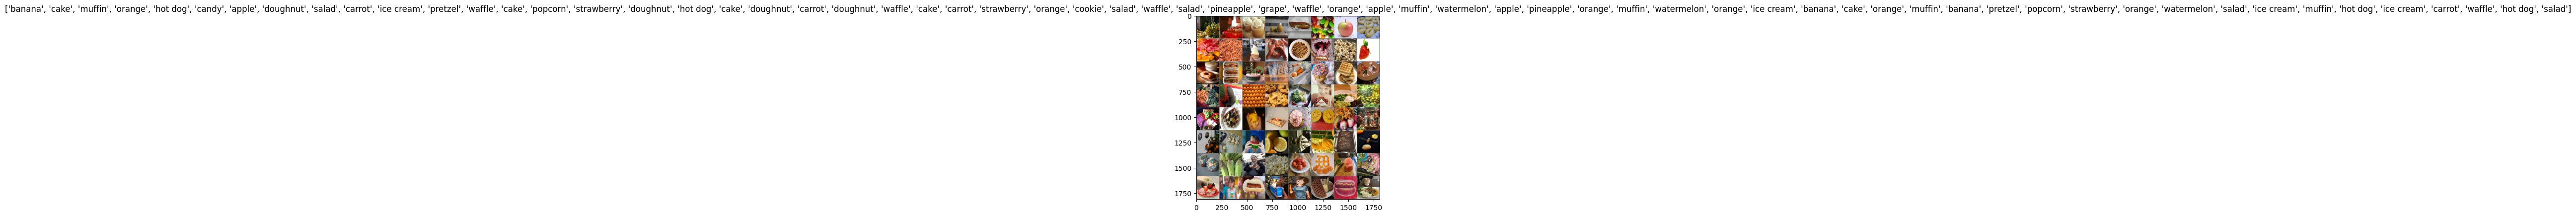

In [153]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [154]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [182]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.ELU(),
    nn.Conv2d(16, 32, 3),
    nn.ELU(),
    nn.Conv2d(32, 128, 3, 3, 2),

    nn.Conv2d(128, 128, 3),
    nn.ELU(),
    nn.Conv2d(128, 128, 3),
    nn.ELU(),
    nn.Conv2d(128, 128, 3, 3, 2),

    nn.Conv2d(128, 128, 3),
    nn.ELU(),
    nn.Conv2d(128, 128, 3),
    nn.ELU(),
    nn.Conv2d(128, 128, 3, 3, 2),

    nn.Conv2d(128, 128, 3),
    nn.ELU(),
    nn.Conv2d(128, 128, 3),
    nn.ELU(),
    nn.Conv2d(128, 128, 3, 3, 2),

    nn.Flatten(),

    nn.Linear(512, 20),
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.3)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7)

Epoch 0/6
----------


OutOfMemoryError: ignored

In [164]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    output = model_fitted(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [165]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

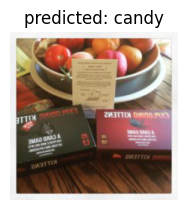

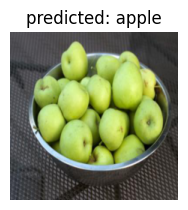

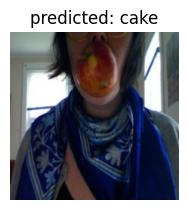

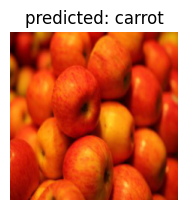

In [166]:
visualize_model(model_fitted, 4)

pineapple


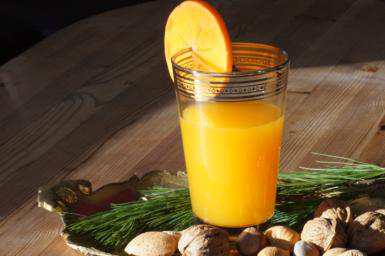

In [171]:
num = 520
print(predict(dataset['test'][num]['image']))
dataset['test'][num]['image']